## Predicting Recurrence and Risk Factors of Differentiated Thyroid Cancer using Explainable AI
### Hunter Malinowski

#### Data Exploration

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [3]:
# load the dataset
df = pd.read_csv("Thyroid_Diff.csv")

# check the first few rows
print("\nFirst 5 rows:")
print(df.head())

# check data types
print("\nData Types:")
print(df.dtypes)


First 5 rows:
   Age Gender Smoking Hx Smoking Hx Radiothreapy Thyroid Function  \
0   27      F      No         No              No        Euthyroid   
1   34      F      No        Yes              No        Euthyroid   
2   30      F      No         No              No        Euthyroid   
3   62      F      No         No              No        Euthyroid   
4   62      F      No         No              No        Euthyroid   

          Physical Examination Adenopathy       Pathology     Focality Risk  \
0   Single nodular goiter-left         No  Micropapillary    Uni-Focal  Low   
1          Multinodular goiter         No  Micropapillary    Uni-Focal  Low   
2  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
3  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
4          Multinodular goiter         No  Micropapillary  Multi-Focal  Low   

     T   N   M Stage       Response Recurred  
0  T1a  N0  M0     I  Indeterminate       No  
1

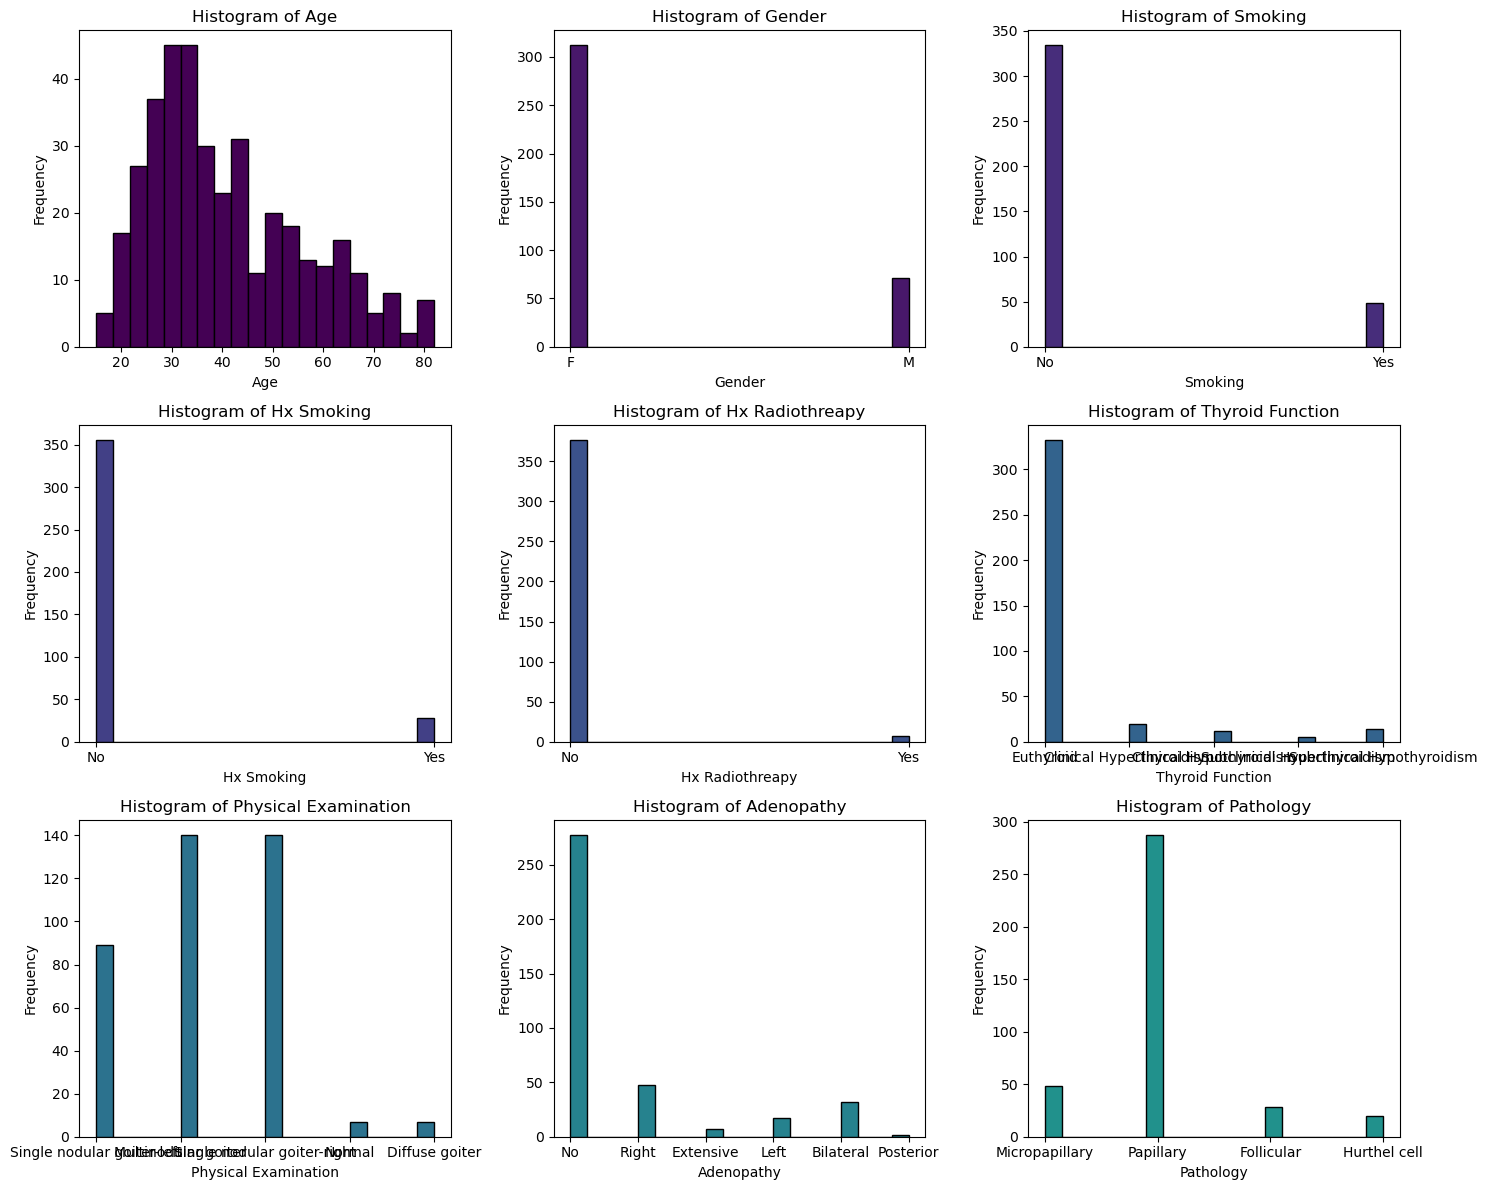

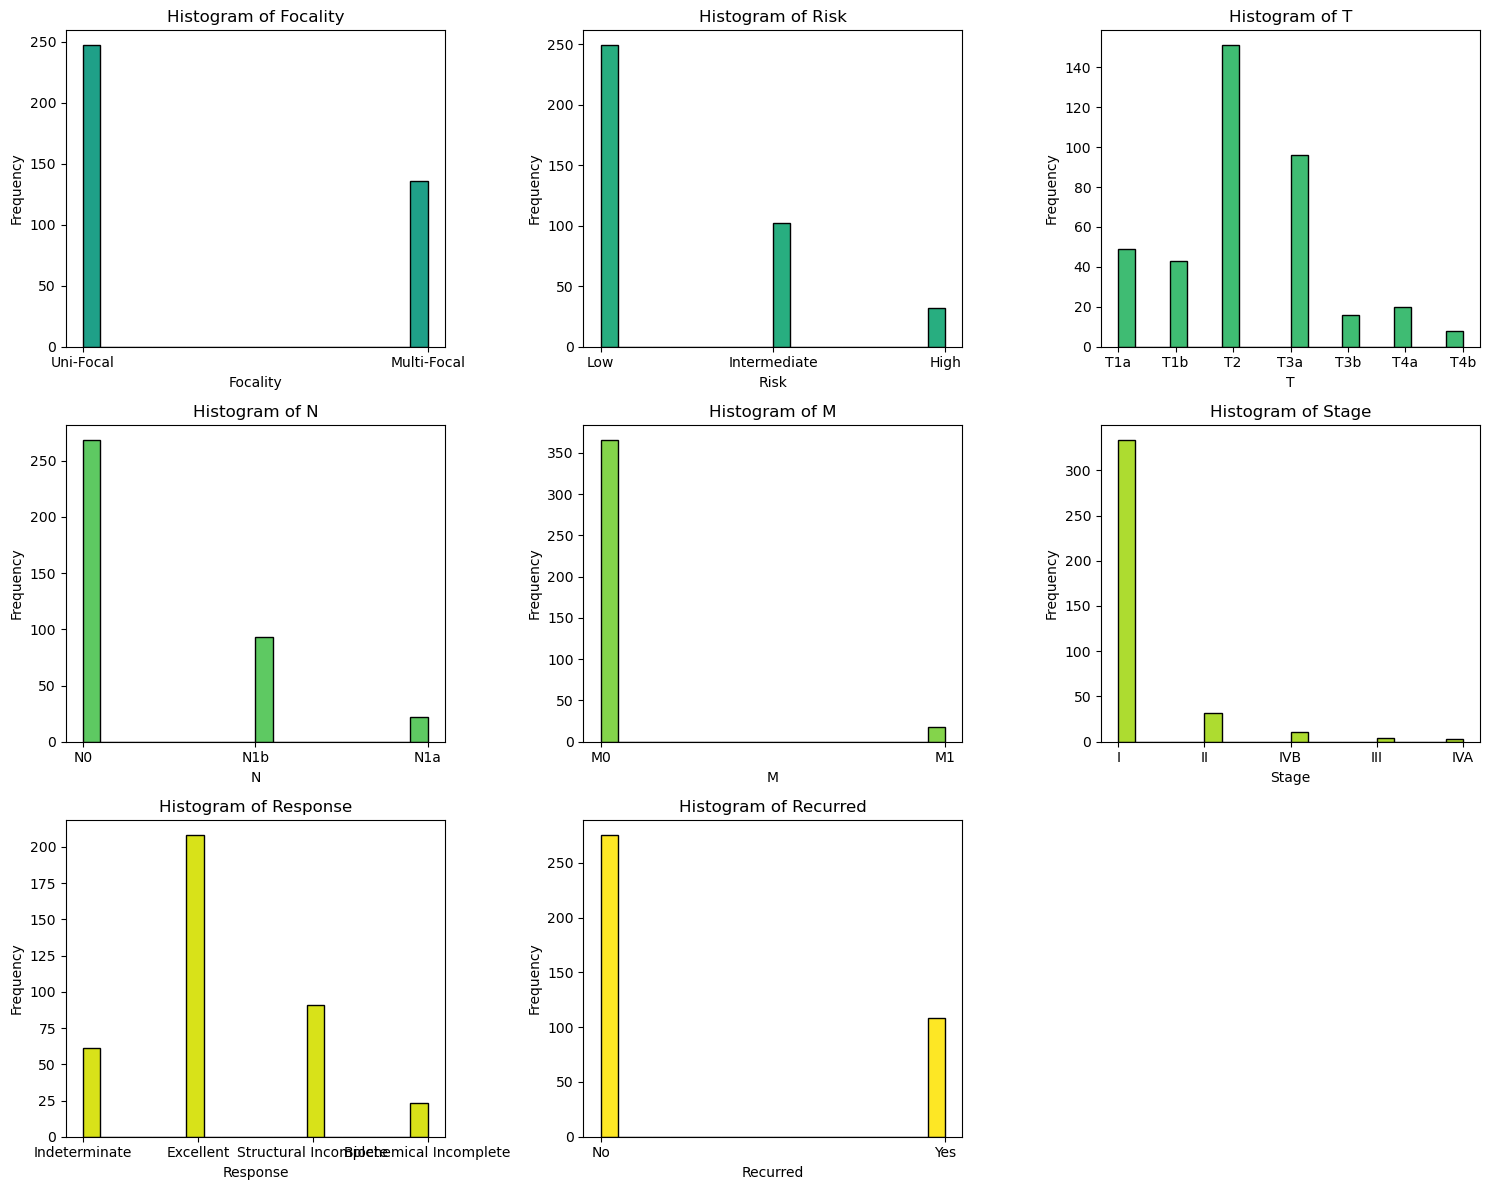

In [4]:
# create histograms to visualize data
columns = df.columns
num_columns = len(columns)
plots_per_page = 9  # 3x3 grid
num_pages = math.ceil(num_columns / plots_per_page)

# create a color list from the viridis colormap
viridis = cm.get_cmap('viridis', num_columns)
colors = [viridis(i / num_columns) for i in range(num_columns)]

for i in range(num_pages):
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for j in range(plots_per_page):
        col_index = i * plots_per_page + j
        if col_index < num_columns:
            col = columns[col_index]
            data = df[col].dropna()
            axes[j].hist(data, bins=20, edgecolor='black', color=colors[col_index])
            axes[j].set_title(f'Histogram of {col}')
            axes[j].set_xlabel(col)
            axes[j].set_ylabel('Frequency')
        else:
            fig.delaxes(axes[j])  # remove unused subplot
    
    plt.tight_layout()
    plt.show()

#### Pre-processing

In [5]:
# encoding categorical variables
# separate target variable
target = 'Recurred'
df[target] = df[target].map({'No': 0, 'Yes': 1}).astype(int)
y = df[target]
df = df.drop(columns=[target])

# identify ordinal multiclass variables
ordinal_mappings = {
    'Risk': ['Low', 'Intermediate', 'High'],
    'Stage': ['I', 'II', 'III', 'IVA', 'IVB'],
    'T': ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b'],
    'N': ['N0', 'N1a', 'N1b'],
    'Response': ['Excellent', 'Indeterminate', 'Biochemical Incomplete', 'Structural Incomplete']
}

# identify nominal variables
binary_cols = [col for col in df.columns if df[col].dropna().nunique() == 2 and col not in ordinal_mappings]
nominal_cols = [col for col in df.select_dtypes(include='object').columns
                if col not in binary_cols and col not in ordinal_mappings]

# conduct ordinal encoding
encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_mappings])
df_ordinal = df[ordinal_mappings.keys()].copy()
df_ordinal = pd.DataFrame(
    encoder.fit_transform(df_ordinal),
    columns=ordinal_mappings.keys(),
    index=df.index
).astype(int)

# binary one-hot encoding
df_binary = pd.get_dummies(df[binary_cols], drop_first=True)

# multiclass nominal one-hot encoding
df_nominal = pd.get_dummies(df[nominal_cols], drop_first=True)

# include any numerical vars
non_categorical_cols = df.select_dtypes(exclude='object').drop(columns=ordinal_mappings.keys(), errors='ignore')

# combine to final df
df_final = pd.concat([non_categorical_cols, df_ordinal, df_binary, df_nominal], axis=1)

# check final dataset
print("Final dataset shape:", df_final.shape)
print(df_final.head())

Final dataset shape: (383, 28)
   Age  Risk  Stage  T  N  Response  Gender_M  Smoking_Yes  Hx Smoking_Yes  \
0   27     0      0  0  0         1         0            0               0   
1   34     0      0  0  0         0         0            0               1   
2   30     0      0  0  0         0         0            0               0   
3   62     0      0  0  0         0         0            0               0   
4   62     0      0  0  0         0         0            0               0   

   Hx Radiothreapy_Yes  ...  Physical Examination_Single nodular goiter-left  \
0                    0  ...                                                1   
1                    0  ...                                                0   
2                    0  ...                                                0   
3                    0  ...                                                0   
4                    0  ...                                                0   

   Physical Examina

#### Model 1: Logistic Regression

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [7]:
# create train/test split
# target column
target = 'Recurred'
X = df_final
y = y

# 70/30 split (stratified random sampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

In [9]:
# define model and hyperparameter grid
logreg = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

# 10-fold CV with grid search
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
grid = GridSearchCV(logreg, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

# best model
best_model = grid.best_estimator_

In [15]:
# model evaluation
# predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]

# specificity helper
def get_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp = cm[0][0], cm[0][1]
    return tn / (tn + fp)

# train metrics
print("Logistic Regression Training Metrics:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))
print("Specificity:", get_specificity(y_train, y_train_pred))
print("AUC:", roc_auc_score(y_train, y_train_proba))

# test metrics
print("\nLogistic Regression Testing Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Specificity:", get_specificity(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

Logistic Regression Training Metrics:
Accuracy: 0.9651567944250871
Precision: 0.9733333333333334
Recall: 0.9012345679012346
F1 Score: 0.935897435897436
Specificity: 0.9902912621359223
AUC: 0.991310080306844

Logistic Regression Testing Metrics:
Accuracy: 0.9791666666666666
Precision: 1.0
Recall: 0.9259259259259259
F1 Score: 0.9615384615384615
Specificity: 1.0
AUC: 0.9908749329039185


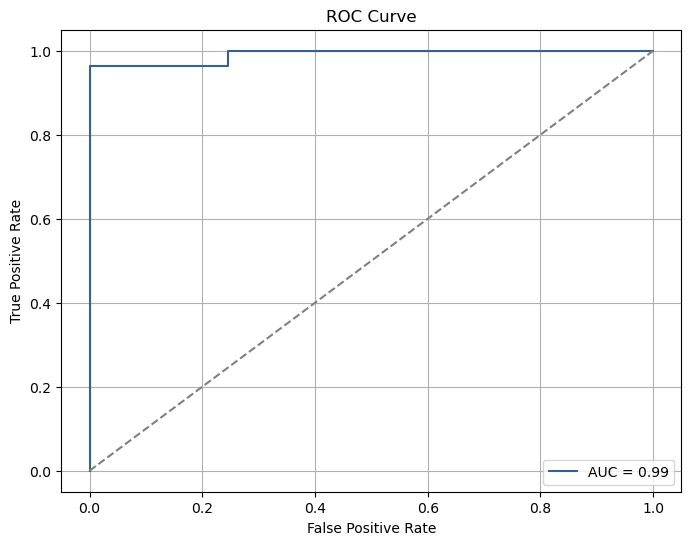

In [16]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_color = viridis(0.3)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color=roc_color, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

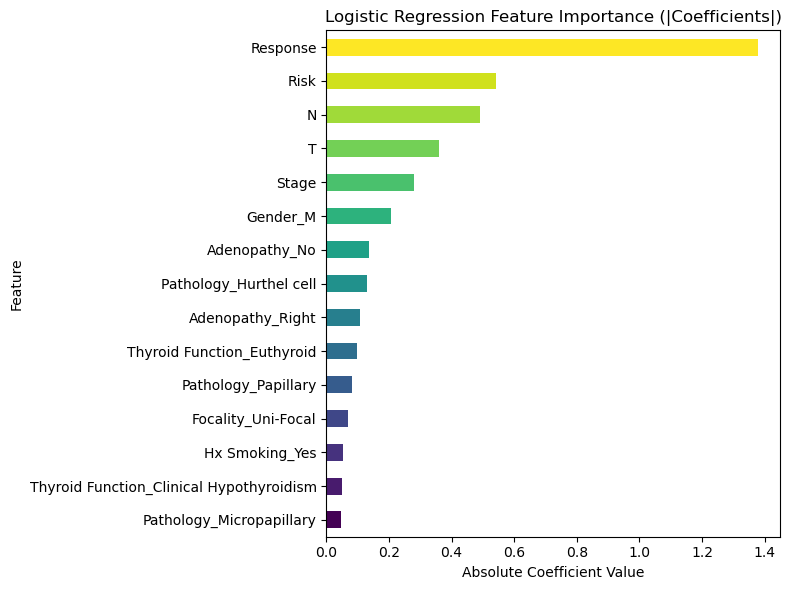

In [19]:
# feature importance plot
# get coefficients
coefficients_lr = best_model.coef_[0]
features_lr = pd.Series(coefficients_lr, index=X.columns)

# top 15 by absolute value
top_features_lr = features_lr.abs().sort_values().tail(15)
colors = cm.viridis(np.linspace(0, 1, len(top_features_lr)))

top_features_lr.plot(kind='barh', color=colors, figsize=(8, 6))
plt.title("Logistic Regression Feature Importance (|Coefficients|)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Model 2: Support Vector Machines

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [21]:
# train-test split
X_svm = df_final
y_svm = y

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y_svm, test_size=0.25, random_state=123, stratify=y_svm
)

In [23]:
# SVM model and parameter grid
svm_model = SVC(probability=True)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'] 
}

svm_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
svm_grid = GridSearchCV(svm_model, svm_param_grid, cv=svm_cv, scoring='f1', n_jobs=-1)
svm_grid.fit(X_train_svm, y_train_svm)

best_svm_model = svm_grid.best_estimator_

In [ ]:
# model evaluation
# predictions
y_pred_svm = best_svm_model.predict(X_test_svm)
y_proba_svm = best_svm_model.predict_proba(X_test_svm)[:, 1]
y_train_pred_svm = best_model.predict(X_train_svm)
y_train_proba_svm = best_model.predict_proba(X_train_svm)[:, 1]

# train metrics
print("SVM Training Metrics:")
print("Accuracy:", accuracy_score(y_train_svm, y_train_pred_svm))
print("Precision:", precision_score(y_train_svm, y_train_pred_svm))
print("Recall:", recall_score(y_train_svm, y_train_pred_svm))
print("F1 Score:", f1_score(y_train_svm, y_train_pred_svm))
print("Specificity:", get_specificity(y_train_svm, y_train_pred_svm))
print("AUC:", roc_auc_score(y_train_svm, y_train_pred_svm))

# test metrics
print("\nSVM Testing Metrics:")
print("Accuracy:", accuracy_score(y_test_svm, y_pred_svm))
print("Precision:", precision_score(y_test_svm, y_pred_svm))
print("Recall:", recall_score(y_test_svm, y_pred_svm))
print("F1 Score:", f1_score(y_test_svm, y_pred_svm))
print("Specificity:", get_specificity(y_test_svm, y_pred_svm))
print("AUC:", roc_auc_score(y_test_svm, y_proba_svm))

SVM Training Metrics:
Accuracy: 0.9651567944250871
Precision: 0.9733333333333334
Recall: 0.9012345679012346
F1 Score: 0.935897435897436
Specificity: 0.9902912621359223
AUC: 0.9457629150185785

SVM Testing Metrics:
Accuracy: 0.9895833333333334
Precision: 1.0
Recall: 0.9629629629629629
F1 Score: 0.9811320754716981
Specificity: 1.0
AUC: 0.9887278582930757


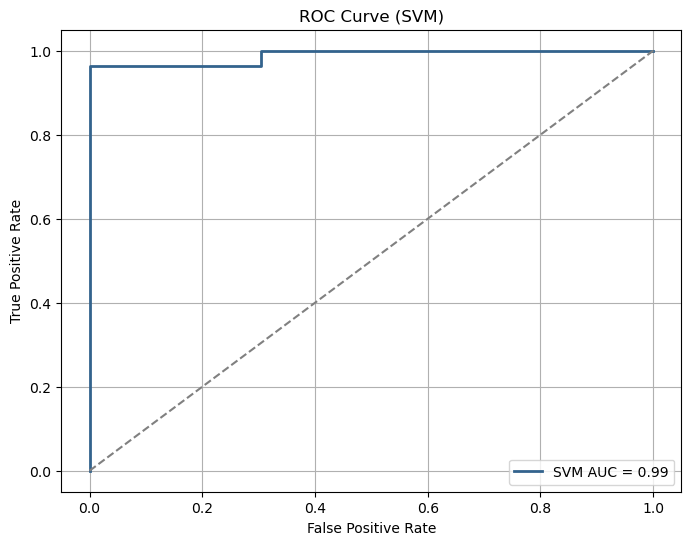

In [27]:
# plot ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test_svm, y_proba_svm)
auc_svm = roc_auc_score(y_test_svm, y_proba_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color=roc_color, label=f'SVM AUC = {auc_svm:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVM)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

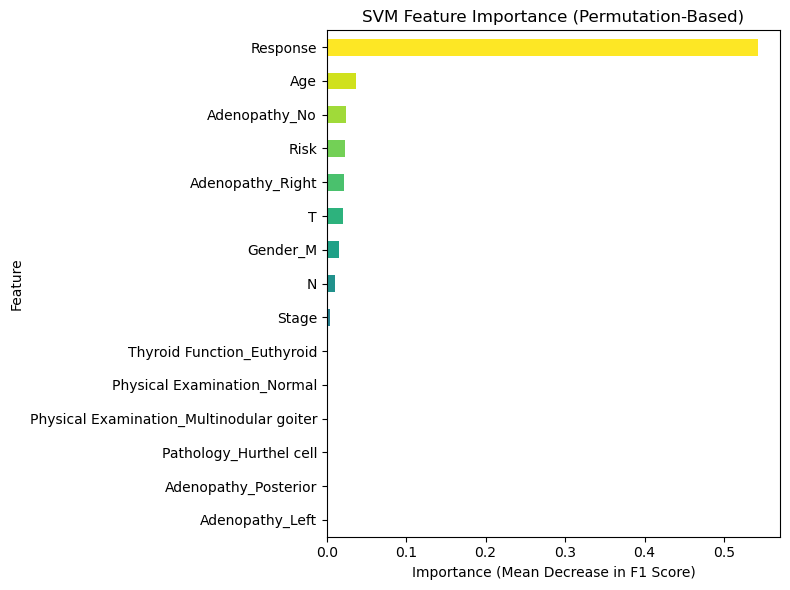

In [28]:
# feature importance plot
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

# compute permutation importance
result = permutation_importance(best_svm_model, X_test_svm, y_test_svm, n_repeats=10, random_state=42, scoring='f1')

# format results
importances = result.importances_mean
feature_names = X_svm.columns
importance_series = pd.Series(importances, index=feature_names)

# select top 15
top_features_svm = importance_series.sort_values().tail(15)
colors = cm.viridis(np.linspace(0, 1, len(top_features_svm)))

# plot
top_features_svm.plot(kind='barh', color=colors, figsize=(8, 6))
plt.title("SVM Feature Importance (Permutation-Based)")
plt.xlabel("Importance (Mean Decrease in F1 Score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Model 3: Random Forests

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [30]:
# train-test split
X_rf = df_final
y_rf = y

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.25, random_state=123, stratify=y_rf
)

In [31]:
rf_model = RandomForestClassifier(random_state=123)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=rf_cv, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_rf, y_train_rf)

best_rf_model = rf_grid.best_estimator_

In [36]:
# predictions
y_pred_rf = best_rf_model.predict(X_test_rf)
y_proba_rf = best_rf_model.predict_proba(X_test_rf)[:, 1]
y_train_pred_rf = best_model.predict(X_train_svm)
y_train_proba_rf = best_model.predict_proba(X_train_svm)[:, 1]

# train metrics
print("Random Forests Training Metrics:")
print("Accuracy:", accuracy_score(y_train_rf, y_train_pred_rf))
print("Precision:", precision_score(y_train_rf, y_train_pred_rf))
print("Recall:", recall_score(y_train_rf, y_train_pred_rf))
print("F1 Score:", f1_score(y_train_rf, y_train_pred_rf))
print("Specificity:", get_specificity(y_train_rf, y_train_pred_rf))
print("AUC:", roc_auc_score(y_train_rf, y_train_pred_rf))

# test metrics
print("\nRandom Forests Testing Metrics:")
print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print("Precision:", precision_score(y_test_rf, y_pred_rf))
print("Recall:", recall_score(y_test_rf, y_pred_rf))
print("F1 Score:", f1_score(y_test_rf, y_pred_rf))
print("Specificity:", get_specificity(y_test_rf, y_pred_rf))
print("AUC:", roc_auc_score(y_test_rf, y_proba_rf))

Random Forests Training Metrics:
Accuracy: 0.9651567944250871
Precision: 0.9733333333333334
Recall: 0.9012345679012346
F1 Score: 0.935897435897436
Specificity: 0.9902912621359223
AUC: 0.9457629150185785

Random Forests Testing Metrics:
Accuracy: 0.9895833333333334
Precision: 1.0
Recall: 0.9629629629629629
F1 Score: 0.9811320754716981
Specificity: 1.0
AUC: 0.9728931830381105


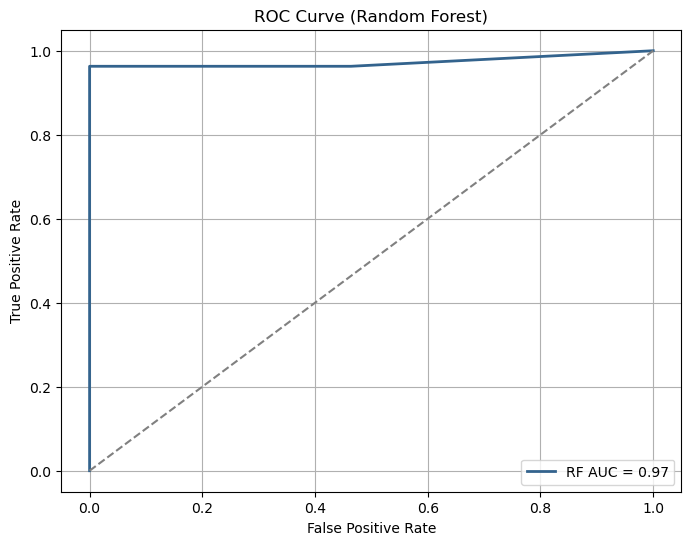

In [37]:
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_proba_rf)
auc_rf = roc_auc_score(y_test_rf, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color=roc_color, label=f'RF AUC = {auc_rf:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

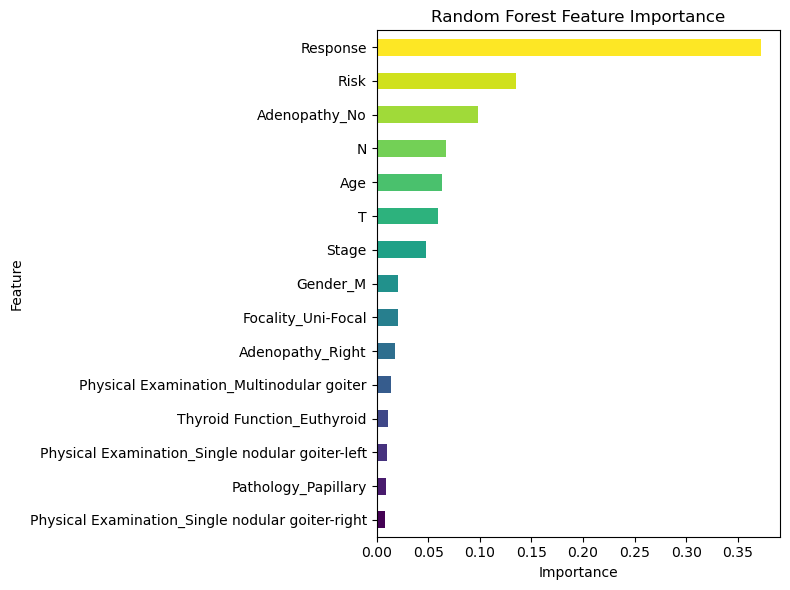

In [38]:
# feature importance plot
# get feature importances
importances_rf = best_rf_model.feature_importances_
features_rf = pd.Series(importances_rf, index=X_rf.columns)

# select top 15
top_features_rf = features_rf.sort_values().tail(15)
colors = cm.viridis(np.linspace(0, 1, len(top_features_rf)))

# plot
top_features_rf.plot(kind='barh', color=colors, figsize=(8, 6))
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Feature Importance Comparison

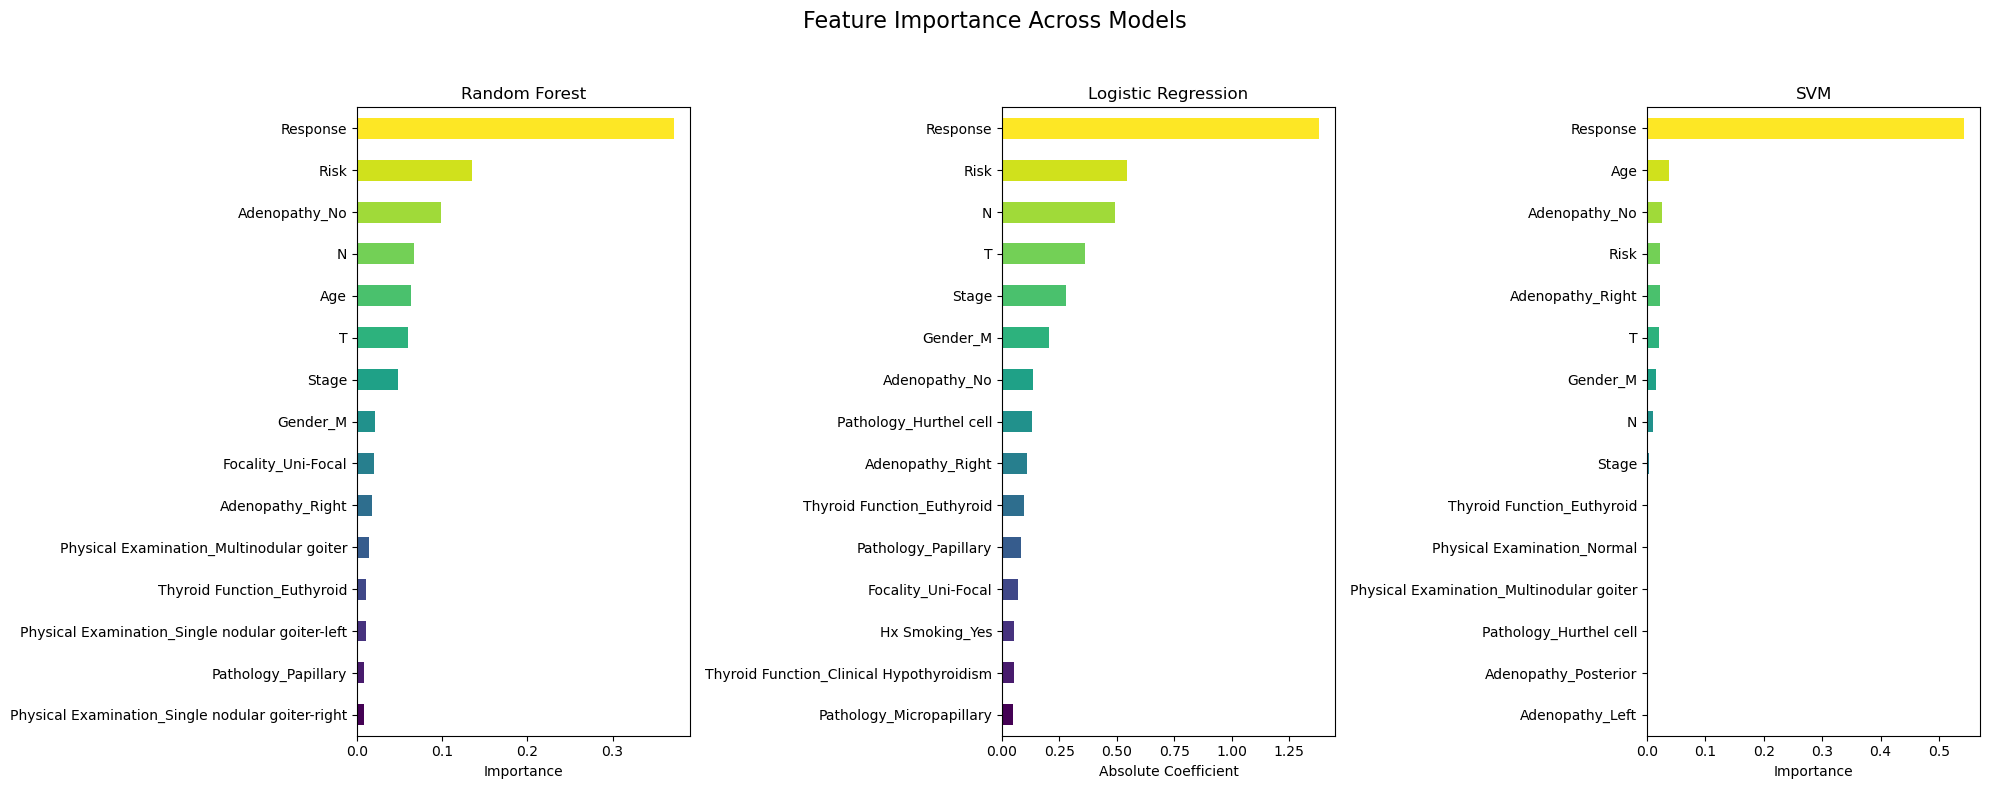

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=False)

# Random Forest
top_features_rf.plot(kind='barh', color=colors, ax=axes[0])
axes[0].set_title("Random Forest")
axes[0].set_xlabel("Importance")

# Logistic Regression
top_features_lr.plot(kind='barh', color=colors, ax=axes[1])
axes[1].set_title("Logistic Regression")
axes[1].set_xlabel("Absolute Coefficient")

# SVM
top_features_svm.plot(kind='barh', color=colors, ax=axes[2])
axes[2].set_title("SVM")
axes[2].set_xlabel("Importance")

# overall formatting
plt.suptitle("Feature Importance Across Models", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### LIME

In [40]:
import lime
import lime.lime_tabular
import numpy as np

In [41]:
# LIME for logistic regression
lime_explainer_lr = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    class_names=['No Recurred', 'Recurred'],
    mode='classification'
)

# explain first prediction
lime_exp_lr = lime_explainer_lr.explain_instance(
    data_row=X_test.iloc[0],
    predict_fn=best_model.predict_proba
)

# show explanation
lime_exp_lr.show_in_notebook()
lime_exp_lr.save_to_file('lime_lr_explanation.html')

c:\Users\hunte\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [42]:
# LIME for SVM
lime_explainer_svm = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_svm),
    feature_names=X_svm.columns,
    class_names=['No Recurred', 'Recurred'],
    mode='classification'
)

# explain first prediction
lime_exp_svm = lime_explainer_svm.explain_instance(
    data_row=X_test_svm.iloc[0],
    predict_fn=best_svm_model.predict_proba
)

# show explanation
lime_exp_svm.show_in_notebook()
lime_exp_svm.save_to_file('lime_svm_explanation.html')

c:\Users\hunte\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [43]:
# LIME for Random Forests
lime_explainer_rf = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_rf),
    feature_names=X_rf.columns,
    class_names=['No Recurred', 'Recurred'],
    mode='classification'
)

# explain first prediction
lime_exp_rf = lime_explainer_rf.explain_instance(
    data_row=X_test_rf.iloc[0],
    predict_fn=best_rf_model.predict_proba
)

# show explanation
lime_exp_rf.show_in_notebook()
lime_exp_rf.save_to_file('lime_rf_explanation.html')

c:\Users\hunte\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
